In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft, fftfreq
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [643]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [644]:
def plot_ts(df : pd.DataFrame, var : str):
    plt.figure(figsize=(20, 6))
    plt.plot(df['Date'], df[var])
    plt.title(f'{var}')
    plt.xticks(ticks=df['Date'][df['Date'].dt.is_month_start],
            labels=df['Date'][df['Date'].dt.is_month_start].dt.strftime('%m/%y'))
    plt.grid(True)

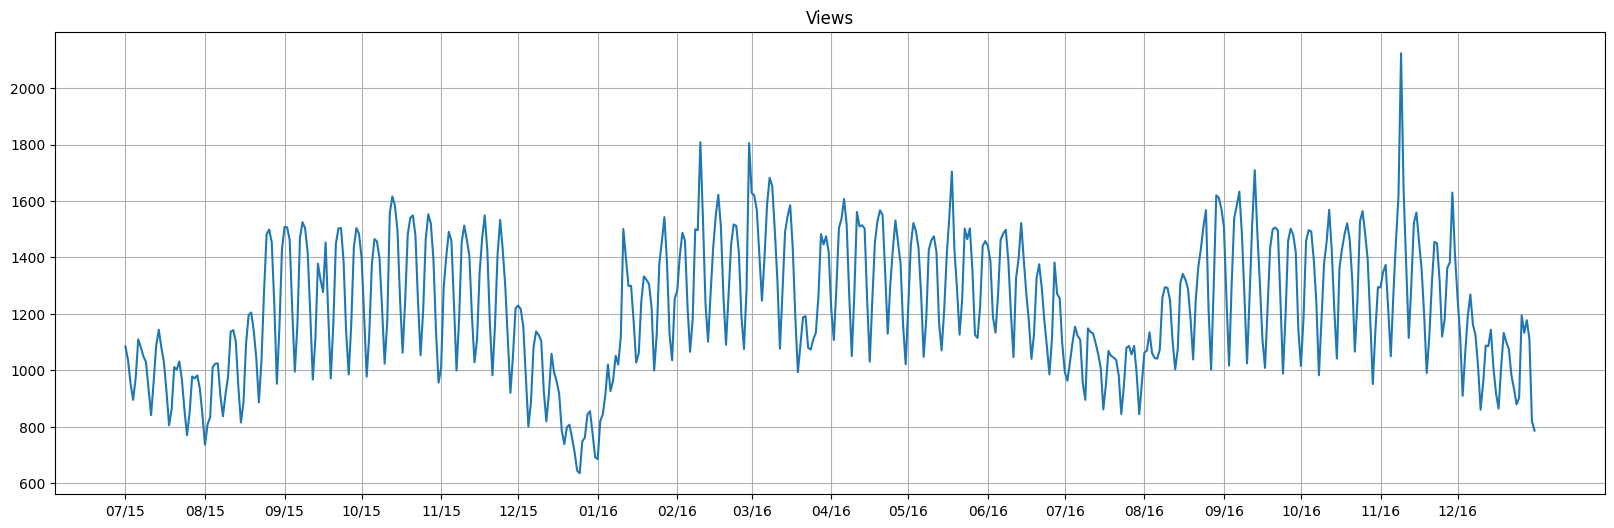

In [645]:
plot_ts(df, 'Views')

In [646]:
def test_stationarity(df : pd.DataFrame, var : str, conf : float=0.05, verbose : bool=False):
    temp = df
    test = adfuller(temp[var])
    test_stat = round(test[0],3)
    pval = round(test[1],3)
    if pval < conf:
        if verbose == True:
            print(f'Time series is stationary with p-value {pval} < {conf} and test statistic {test_stat}')
        return 0, temp
    else:
        if verbose == True:
            print(f'Time series is not stationary with p-value {pval} < {conf} and test statistic {test_stat}')
            print('Differencing...')
        diff = temp[var].diff().dropna()
        test = adfuller(diff)
        test_stat = round(test[0],3)
        pval = round(test[1],3)
        if pval < conf:
            if verbose == True:
                print(f'Time series is stationary with p-value {pval} < {conf} and test statistic {test_stat}')
            temp_diff = temp[var].diff().dropna().to_frame(name=var+'_diff')
            temp = temp.join(temp_diff, how='left')
            return 1, temp
        else:
            print('Time series is not stationary after differencing')      
            return

In [647]:
def plot_spec(df : pd.DataFrame, var : str):
    data = df[var].values
    n = len(data)
    fft_vals = np.abs(fft(data))
    freq = fftfreq(n, d=1)
    pos_freq = freq[:n // 2]
    pos_magnitude = fft_vals[:n // 2]
    with np.errstate(divide='ignore'):
        periods = 1 / pos_freq
    
    l = [[pos_magnitude[i], periods[i]] for i in range(len(pos_magnitude))]
    l.sort(key=lambda x: x[0], reverse=True)
    print(f'Dominant frequencies, which correspond to seasonal cycles: {[int(l[i][1]) for i in range(1,4)]}')
    plt.figure(figsize=(20, 5))
    plt.plot(periods, pos_magnitude)
    plt.xlim([1, 15])
    plt.xticks(np.arange(1, 15, 1))
    plt.title("Spectral Plot for Seasonality Detection")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.grid(True)

In [648]:
def plot_cf(df : pd.DataFrame, var : str, type : str, lags : int = 30):
    df = df.dropna().reset_index(drop=True)
    if type == 'pacf':
        fig = tsaplots.plot_pacf(df[var], lags=lags)
        plt.title(f'PACF of {var}')
        fig.figure.set_size_inches(20, 6)
        cf_vals, civals = sm.tsa.pacf(df[var], nlags=lags, alpha=0.01)
        civals = civals - cf_vals.reshape(-1,1)
        plt.fill_between(x=range(lags+1), y1=civals[:,0], y2=civals[:,1], color='gray', alpha=0.1)
    
    if type == 'acf':
        fig = tsaplots.plot_acf(df[var], lags=lags)
        plt.title(f'ACF of {var}')
        fig.figure.set_size_inches(20, 6)
        cf_vals, civals = sm.tsa.acf(df[var], nlags=lags, alpha=0.01)
        civals = civals - cf_vals.reshape(-1,1)
        plt.fill_between(x=range(lags+1), y1=civals[:,0], y2=civals[:,1], color='gray', alpha=0.1)

In [649]:
def plot_subseries(df : pd.DataFrame, var : str): 
    df["Weekday"] = df["Date"].dt.day_name()
    df["Week"] = df["Date"].dt.isocalendar().week
    weeks = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df["Weekday"] = pd.Categorical(df["Weekday"], categories=weeks, ordered=True)
    df = df.sort_values(by=["Weekday", "Date"])
    count = 0
    colors = plt.colormaps["Blues"](np.linspace(0.8, 0.8, len(weeks)))
    plt.figure(figsize=(20, 6))
    plt.title(f'Subseries plot of {var} by weekdays')
    plt.grid(True)
    for i,day in enumerate(weeks):
        temp = df[df["Weekday"] == day]
        n = len(temp)
        xvals = range(count, count + n)
        plt.plot(xvals, temp[var], lw = 1.2, color=colors[i])
        plt.plot(xvals, temp[var].mean() * np.ones(n), linestyle="--", color="black", lw = 1)
        count = count + 100
        plt.xticks([50,150,250,350,450,550,650], weeks)
    

In [650]:
def main(df : pd.DataFrame, var : str, conf : float=0.05, lags : int=30):
    test_stationarity(df, var, conf, verbose=True)
    temp = df.copy()
    var_diff1 = var+'_diff1'
    var_diff7 = var+'_diff7'
    temp[var_diff1] = df[var].diff(1)
    temp[var_diff7] = temp[var].diff(7)

    plot_ts(df, var)
    plot_ts(temp, var_diff1)
    plot_spec(df, var)
    plot_subseries(temp, var_diff1)
    plot_ts(temp, var_diff7)
    plot_subseries(temp, var_diff7)

    t = temp.dropna()
    t = t[['Date',var_diff7]]
    t.set_index('Date', inplace=True)
    sd = seasonal_decompose(t, model='additive').plot(resid=False)
    sd.figure.set_size_inches(20, 6)

    plot_cf(temp, var, 'acf', lags=lags)
    plot_cf(temp, var, 'pacf', lags=lags)
    plot_cf(temp, var_diff1, 'acf', lags=lags)
    plot_cf(temp, var_diff1, 'pacf', lags=lags)
    plot_cf(temp, var_diff7, 'acf', lags=lags)
    plot_cf(temp, var_diff7, 'pacf', lags=lags)

Time series is stationary with p-value 0.034 < 0.05 and test statistic -3.014
Dominant frequencies, which correspond to seasonal cycles: [183, 6, 7]


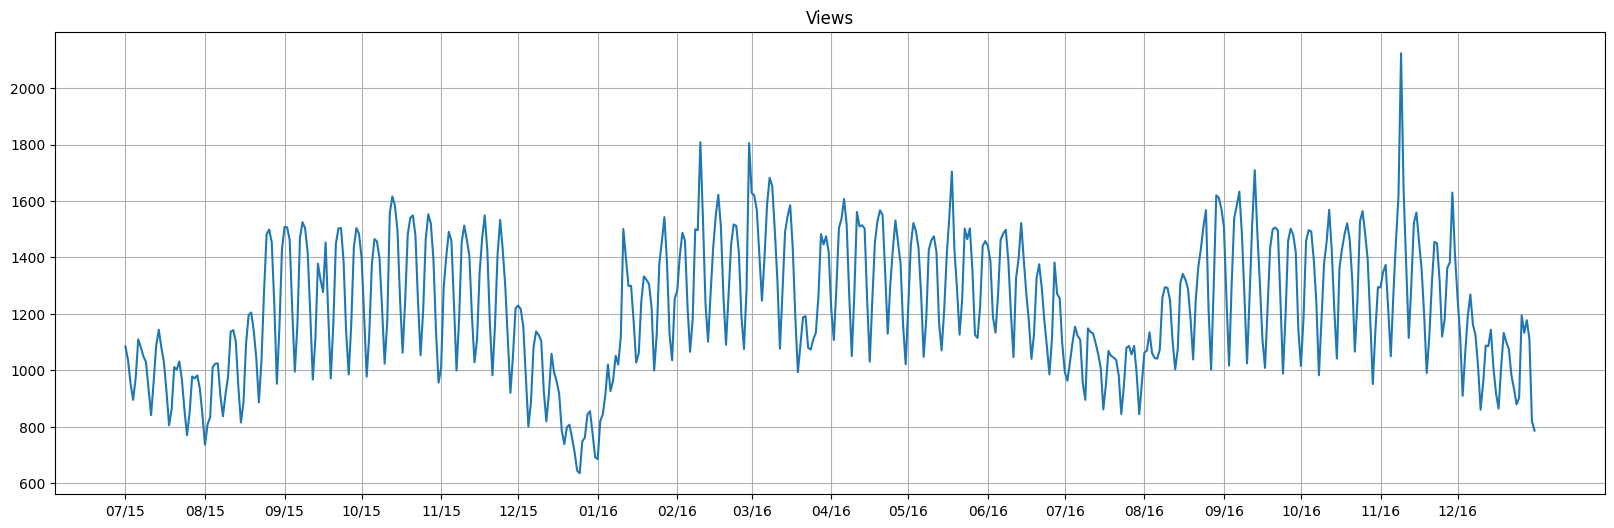

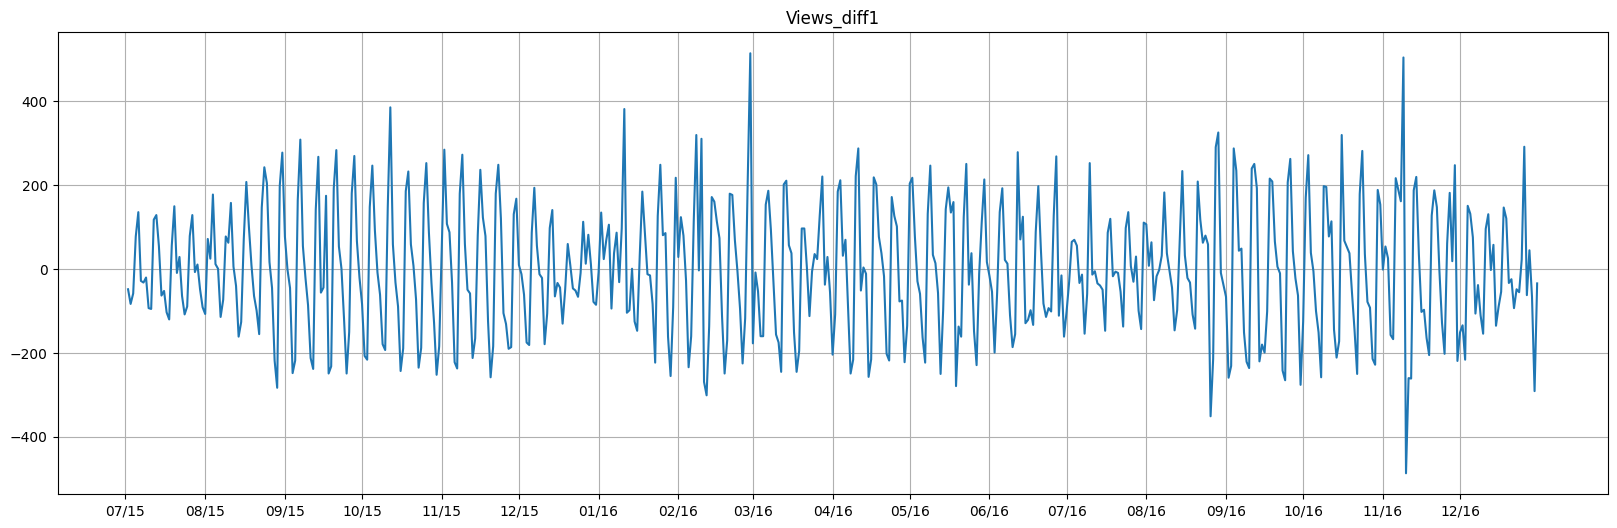

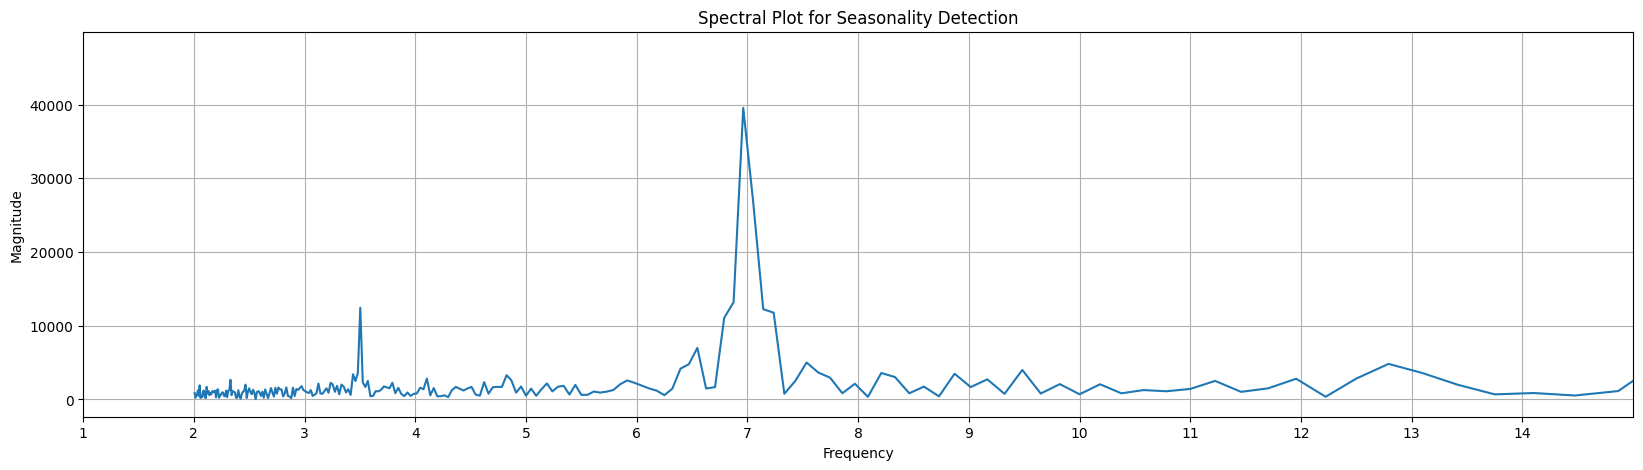

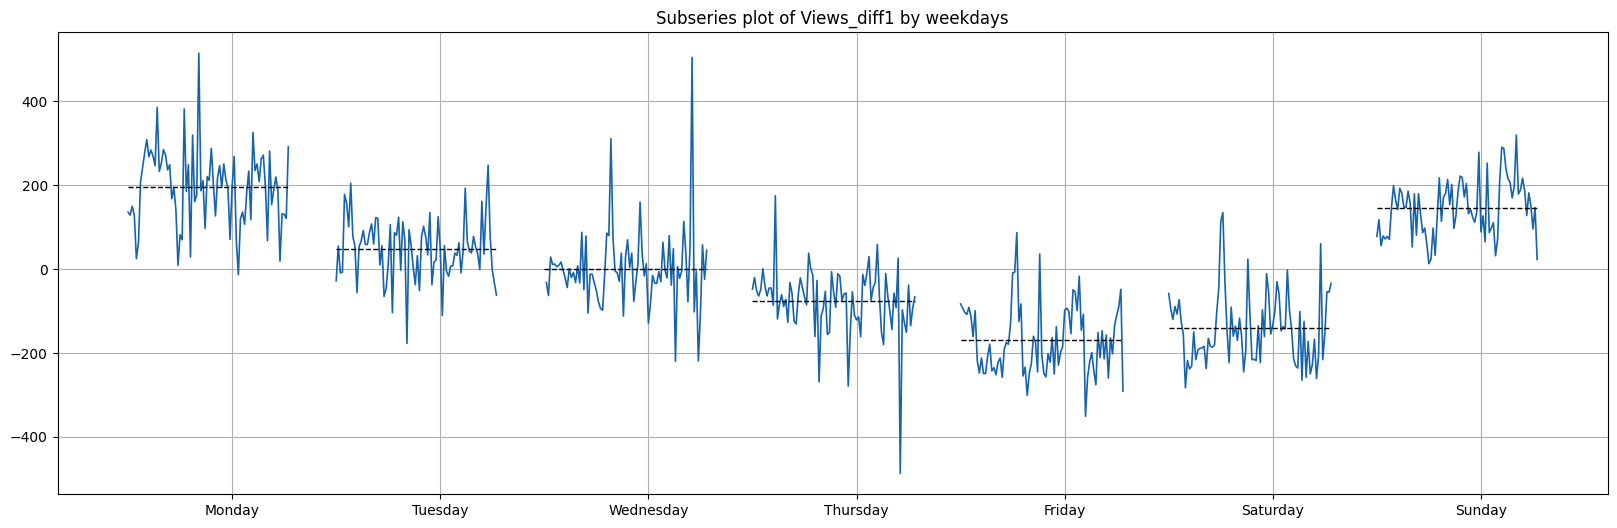

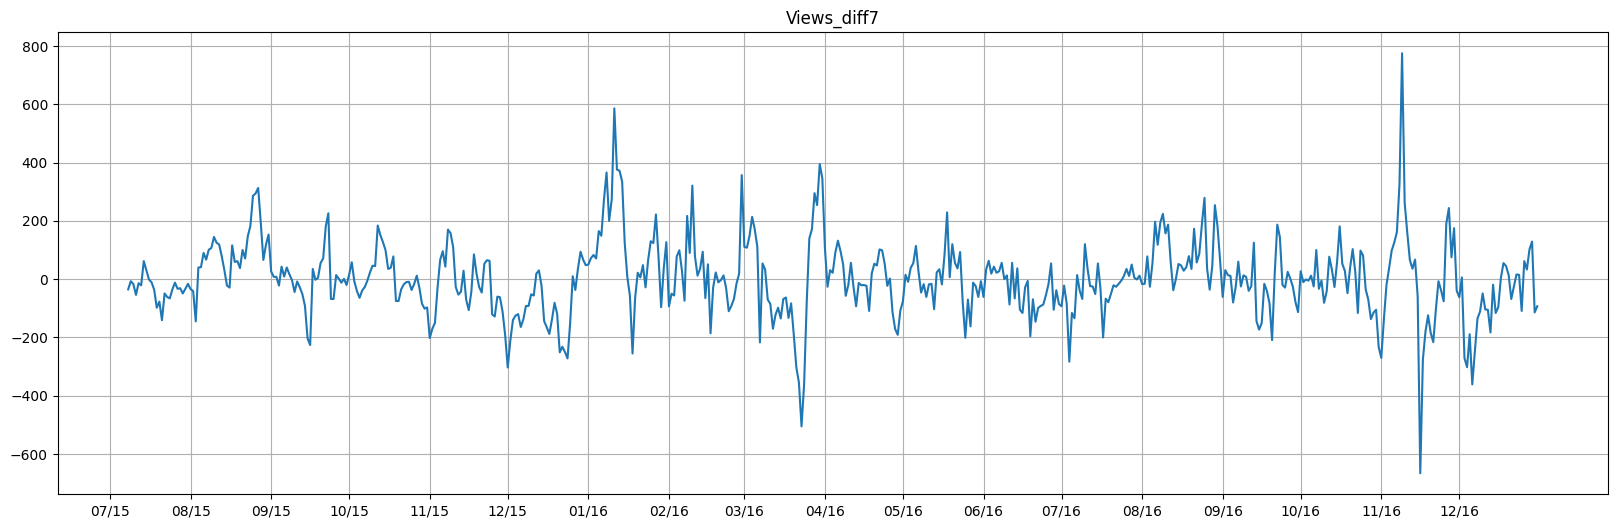

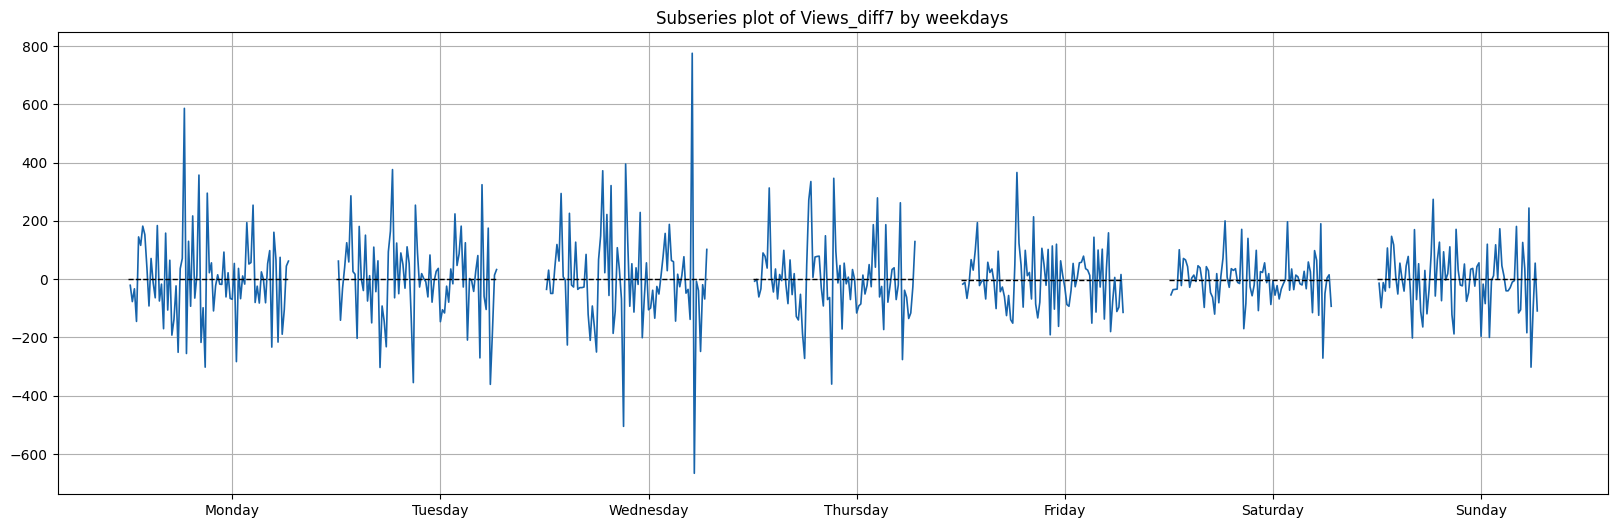

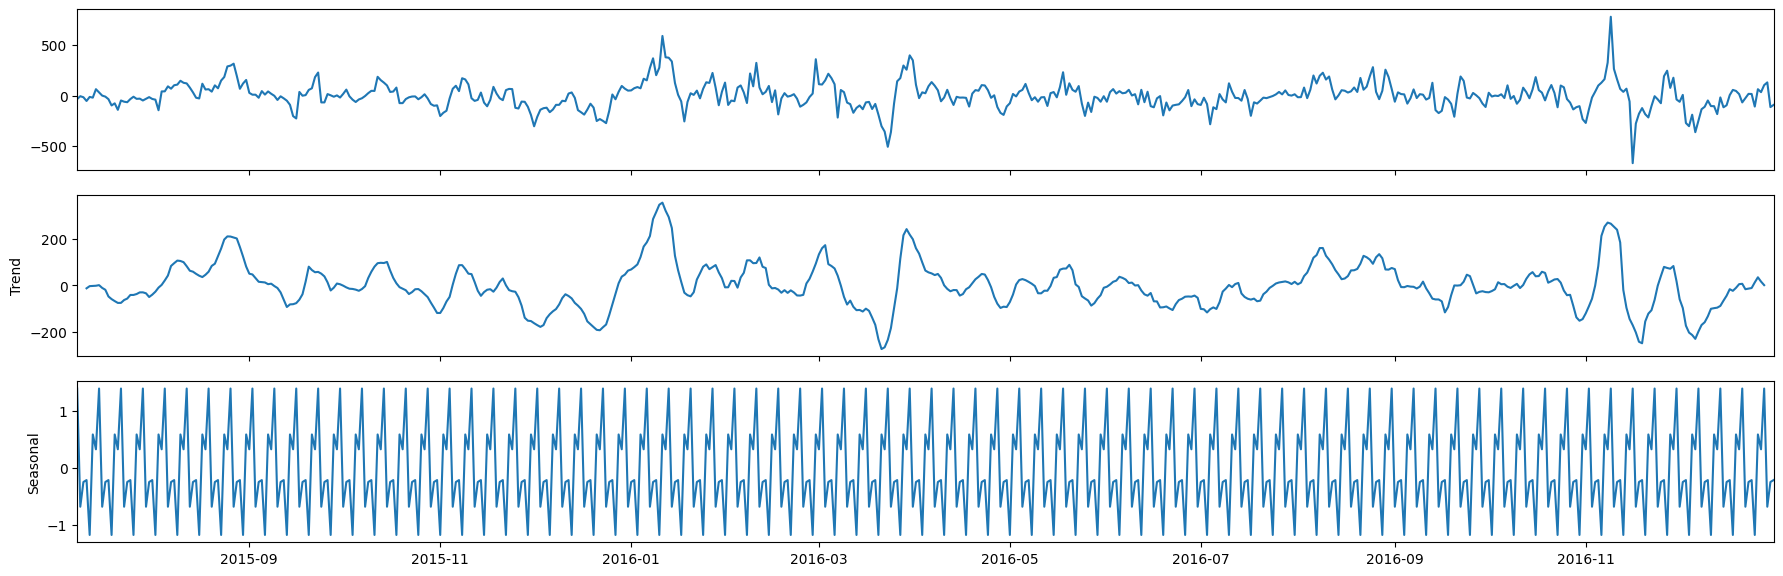

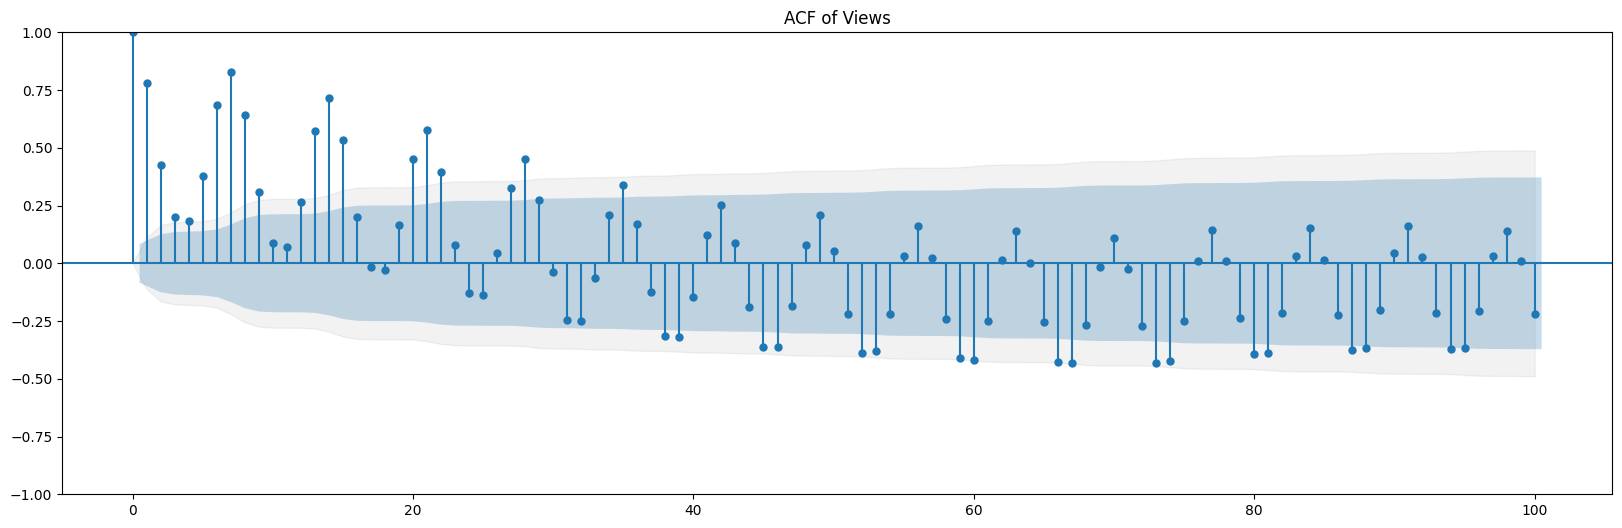

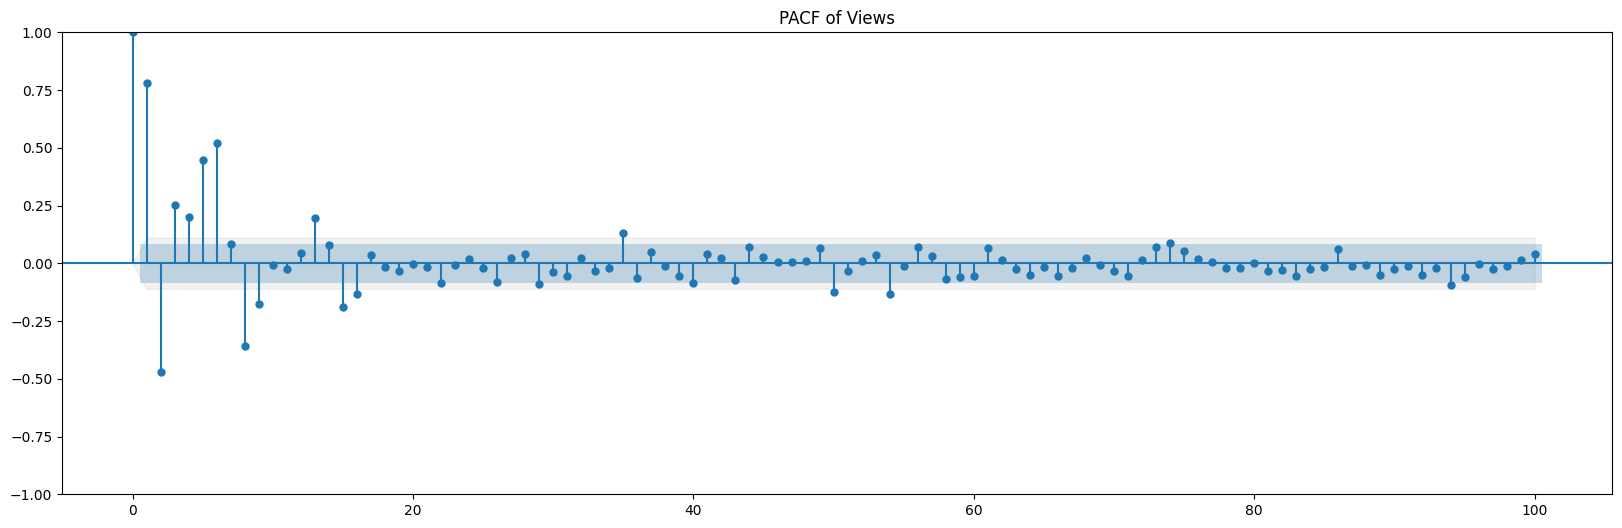

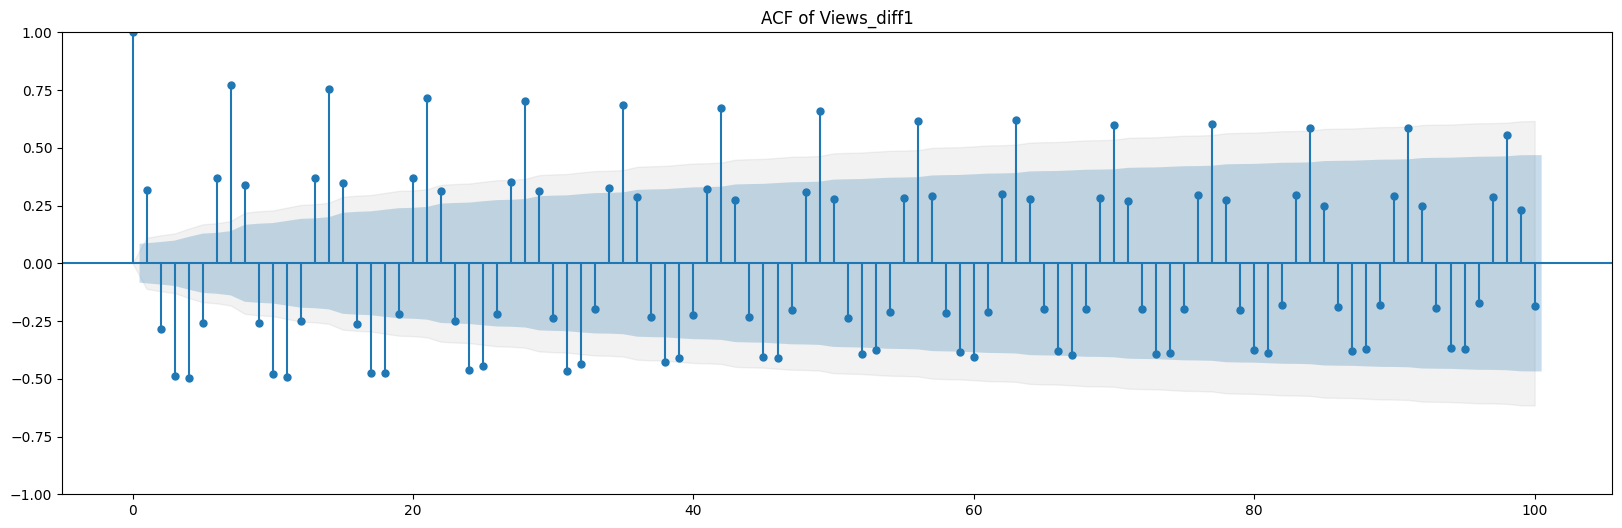

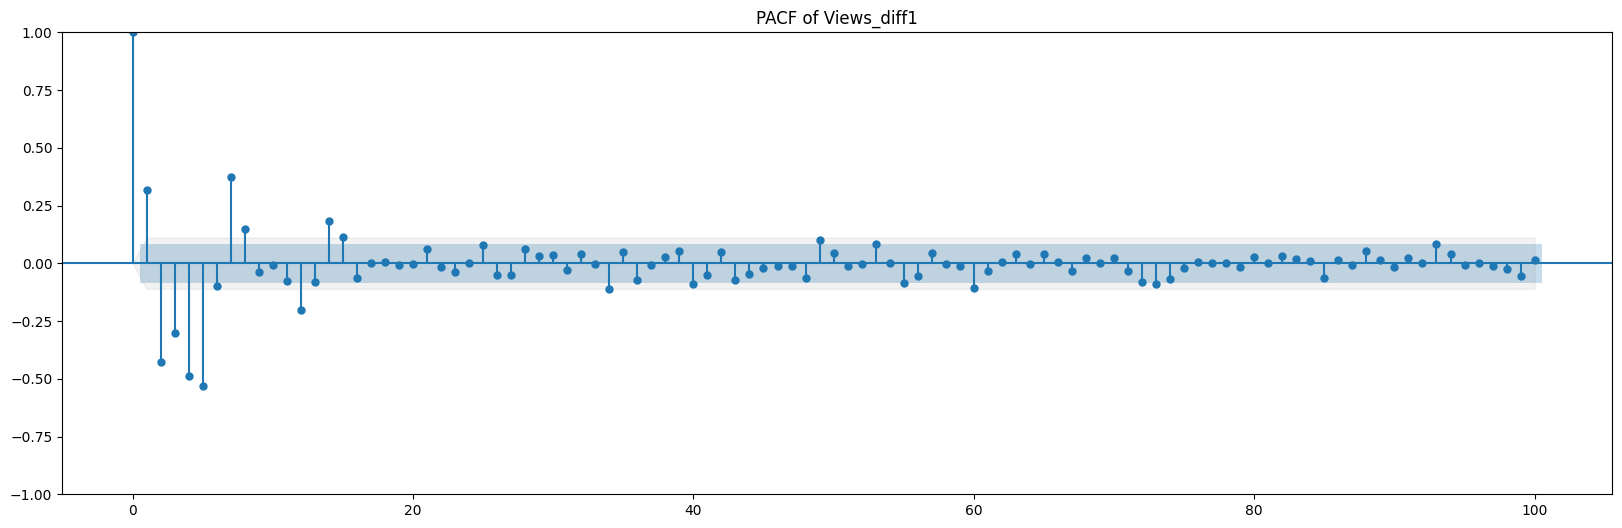

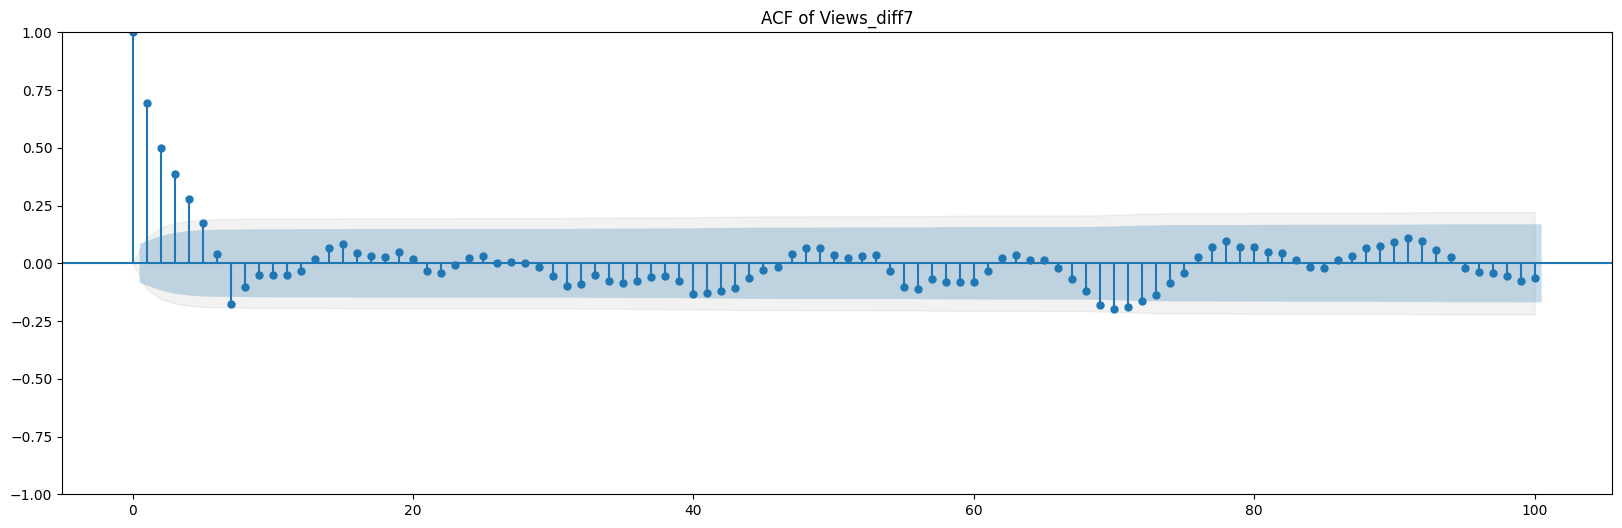

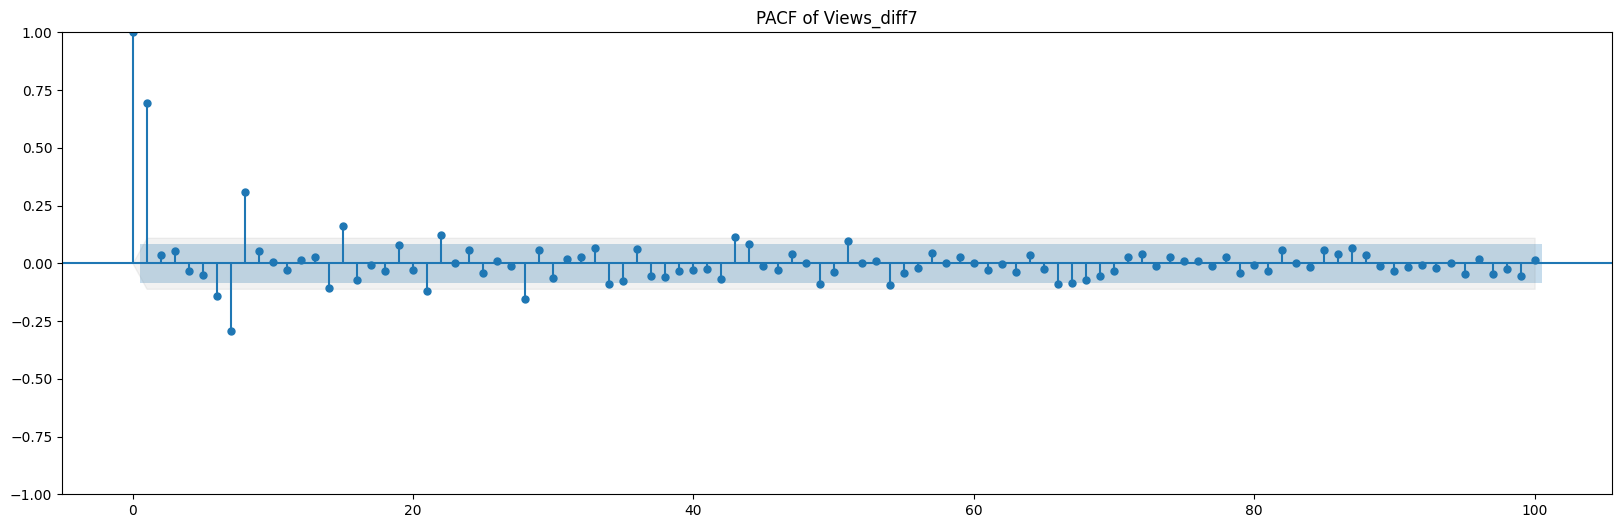

In [651]:
main(df, 'Views', conf=0.05, lags=100)

The autocorrelation plot shows an alternating pattern of positive and negative spikes. It also shows a repeating pattern every 7 lags, which indicates a seasonality effect.

A significant seasonal pattern is obvious in the subseries plot, so we need to include seasonal terms

This autocorrelation plot shows a mixture of exponential decay and a damped sinusoidal pattern. This indicates that an AR model, with order greater than one, may be appropriate. We generate a partial autocorrelation plot to help identify the order.

The partial autocorrelation plot suggests that an AR(1) model might be appropriate since the partial autocorrelation becomes zero after the first lag. The lag 7,8 are also significant, indicating some remaining seasonality.

In [781]:
def forecast(df : pd.DataFrame, var : str, steps : int, order : tuple=(1,0,0), seasonal_order : tuple=(0,0,0,0), conf : float=0.05):
    train = df[:-steps]
    val = df[-steps:]
    model = SARIMAX(train[var],
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=True,
                    enforce_invertibility=True)
    result = model.fit(disp=0)
    print(f'AIC of SARIMA ({order}) ({seasonal_order}): {round(result.aic,3)}')
    # result.plot_diagnostics(figsize=(15, 8))
    forecast_result = result.get_forecast(steps=steps)
    forecast_vals = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=conf)
    plt.figure(figsize=(20, 6))
    plt.plot(df['Date'], df[var], label='Actual')
    plt.plot(val['Date'], forecast_vals, label='Forecast', color='red')
    plt.fill_between(val['Date'],
                    conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                    color='pink', alpha=0.4, label=f'{(1-conf)*100}% CI')
    plt.legend(loc='upper left')

AIC of SARIMA ((7, 0, 0)) ((0, 0, 0, 0)): 6177.09


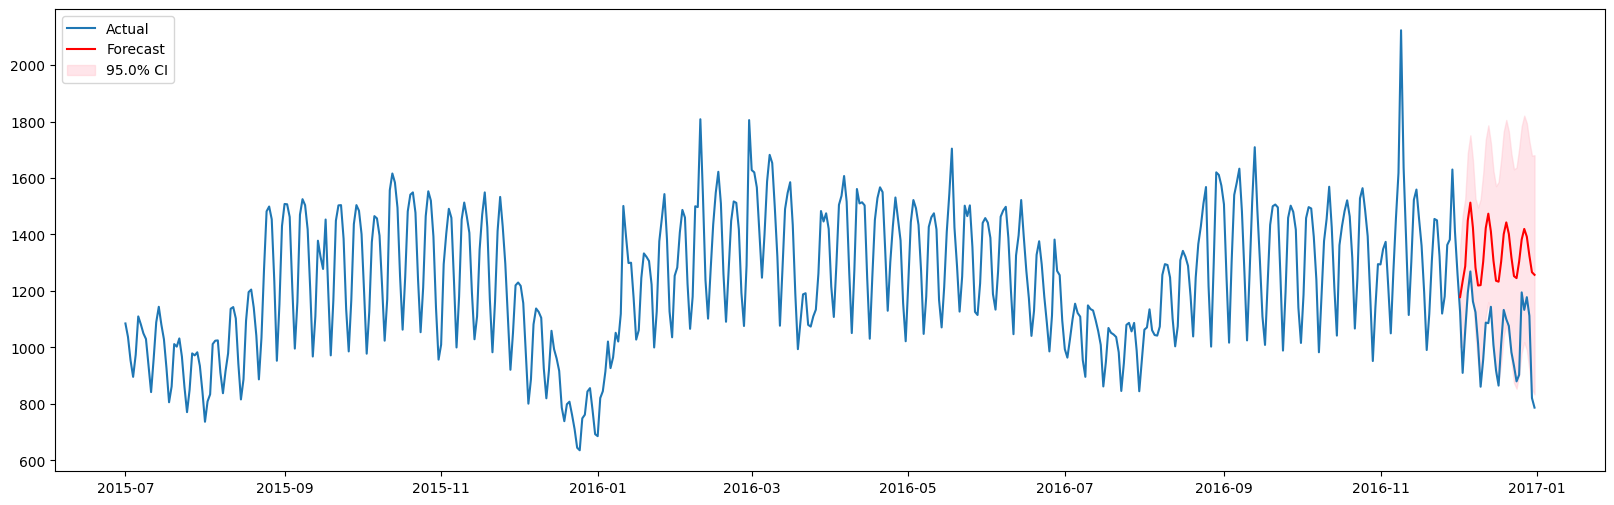

In [782]:
forecast(df, 'Views', 30, order=(7,0,0))

AIC of SARIMA ((1, 1, 0)) ((7, 0, 0, 7)): 6095.664


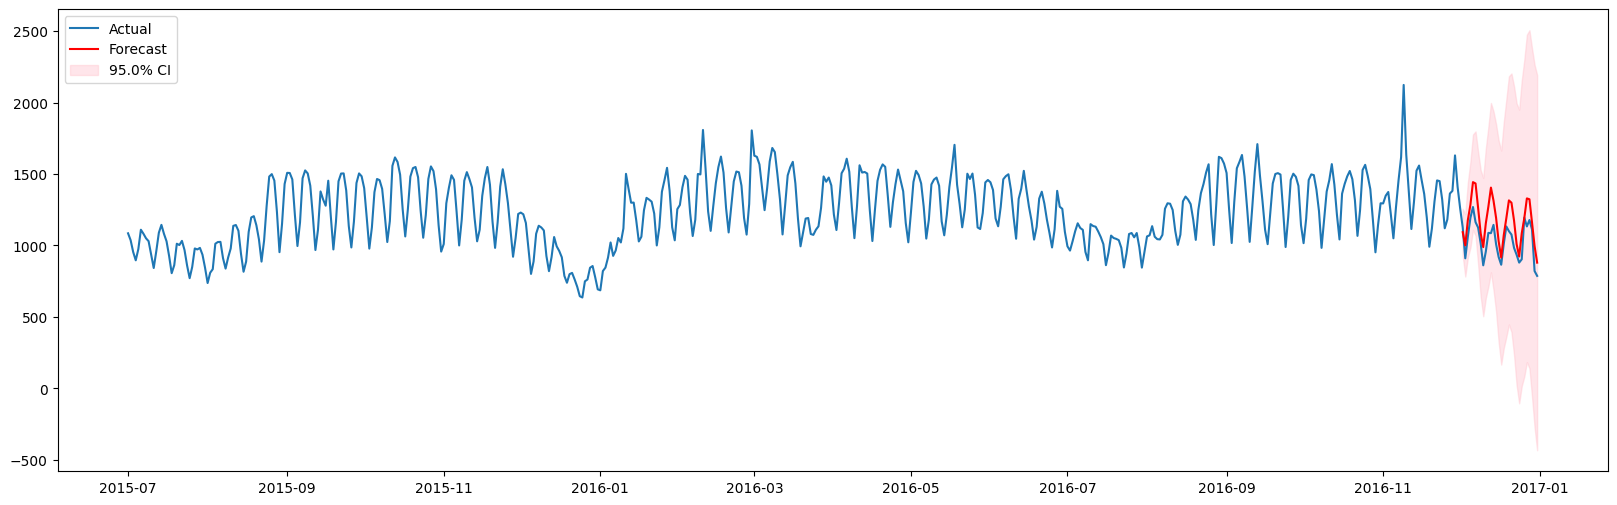

In [783]:
forecast(df, 'Views', 30, order=(1,1,0), seasonal_order=(7,0,0,7))